## Description
Solve a TSP setup in which, after an initial solution is in-hand, we would like to modify the given circuit by adding a few more stops. Find a good way of inserting these additional stops into the given TSP solution.


## Notes

* seems like solving a recurring path-planning problem
   * most of the points should be present in the 'daily' path, with one or two additional points added that must also be visited each time the route is planned
   * the 'naive route' suggested by her boss should never be followed exactly, maybe this is the initial TSP-heuristic solution?
   * assume from Jane's desire to be outdoors that she will be walking, assume triangle-inequality holds for all the walking routes that she can take
* I have no idea what a "fully flexed service" is...maybe that is has many features and flexibility in generating routes?   
* use a traveling salesman problem (TSP) heuristic to get an initial path, to which a few of the 'interesting stops' can be inserted
* since this problem relates to a mail route and does not require the calculation of a real Hamiltonian cycle, we should allow some legs or paths between stops to be reused if they result in a better path length


## Setup
* need a basic "map" with few dozen mail stops, but also with many more "points of interest"
* to make it interesting (otherwise a trivial, greedy algorithm would probably work optimally), we will randomly allow connecting paths between some stops, but not between all stops 
* suppose a grid of 16 km^2 with the post office at the origin (0,0); fixing the seed, select initial set of random stops, and then populate the paths between nodes

## Ideas
* On solving for allowed route through other way-points: 
  * use 'as-the-crow-flies' distance to solve TSP problem (via greedy NN), then attempt to find actual route via Diskstra et al.
  * try modifying the greedy nearest-neighbor approach with a recourse mechanism that allows the current leg to replace endpoints with the 3-5 previous legs and to check in the accumulated length for those leading legs can be improved


In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.sparse as sprs
from copy import deepcopy
import tqdm
import itertools
from tsp_project.gen_data import (generate_graph, generate_walkways_from_complete_graph, 
        generate_mail_stops, generate_interesting_stops)
from tsp_project.algo import TSP
from tsp_project.plot_data import plot_mail_route
import pickle
import hashlib
import os
import pandas as pd

### Data generation
We generate a grid of stop in a given field size, then save it to binary for loading and working with it in the future.

In [2]:
# intialize field of random stops - this takes the most time to run
picklename = 'basic_neighbhor_stops'
ext = '.bin'
files = [f for f in os.listdir('./') if picklename in f]
if files:
    print(f'loading locations from binary file (found: {len(files)} possible files)')
    with open(files[0], 'rb') as rfile:
        stop_locations, dist_mat, xrange = pickle.loads(rfile.read())

    # check the hash of the data
    m = hashlib.md5()
    m.update(stop_locations)
    hsh = str(m.digest())[1:]
    file_hash = files[0][len(picklename)+1:].strip(ext)
    print(f'found matching data hash: {file_hash == hsh}')
else:
    stop_locations, dist_mat, xrange = generate_graph(
            nstops_all=1000, grid_size_noise_std=1., base_dist=2., seed=40, debug=1)
    m = hashlib.md5()
    m.update(stop_locations)
    hsh = m.digest()
    with open(picklename + '_' + str(hsh) + ext, 'wb') as wfile:
        wfile.write(pickle.dumps((stop_locations, dist_mat, xrange)))
print(stop_locations.shape)

final distance matrix shape (1000, 1000)
(1000, 2)


### Limited edge connections
Force a limited set of connections to be present between nodes in the graph.

In [3]:
# udpate distance matrix to reflect the edges by which nodes are connected in local areas
walkways, islanded = generate_walkways_from_complete_graph(dist_mat, xrange, max_nbhrs=10,
        walkway_dist_laplace_param=0.12, fix_islands=True, seed=46, debug=1)

number of init connecting paths: 5048 | allowed dist 0.438 +/- 0.428
number of questionably connected stops: 6


### Fixed stops
Generate a fixed number of stops as the base route.

In [4]:
# get mail stops
manual_add = [433, 726]
mail_stop_indices = generate_mail_stops(
    dist_mat, xrange, nstops_mail=30, manual_add=manual_add,
    mail_stop_dist_laplace_param=0.22, po_start=0, seed=47, debug=1)

mail stops to visit
[0, 407, 944, 720, 801, 145, 219, 688, 684, 479, 164, 892, 371, 756, 677, 695, 796, 612, 209, 726, 370, 751, 620, 180, 270, 301, 486, 843, 186, 433, 642, 660, 457]


### Solve the path problem with different methods
NOTES:
* the 'direct solve' label referes to the solution where all edges are allowed, this is done first with an as-the-crow-flies distance, the solution is then expanded with Dijkstra shortest paths between these stops
* not the runtimes for the various algorithm, random, for example, is much worse given its computational consumption

finding approximate best routes for 33 stops
greedy_NN_recourse algorithm
   runtime     : 0.107s
   route dist  : [coarse: 20.492, fine: 25.220]
   validity    : [True] expanded[True]
   revisit_frac: [0.228]
finding approximate best routes for 33 stops
greedy_NN algorithm
   runtime     : 0.089s
   route dist  : [coarse: 17.862, fine: 22.418]
   validity    : [True] expanded[True]
   revisit_frac: [0.170]
finding approximate best routes for 33 stops
random algorithm
   runtime     : 0.760s
   route dist  : [coarse: 36.449, fine: 42.500]
   validity    : [True] expanded[True]
   revisit_frac: [0.698]


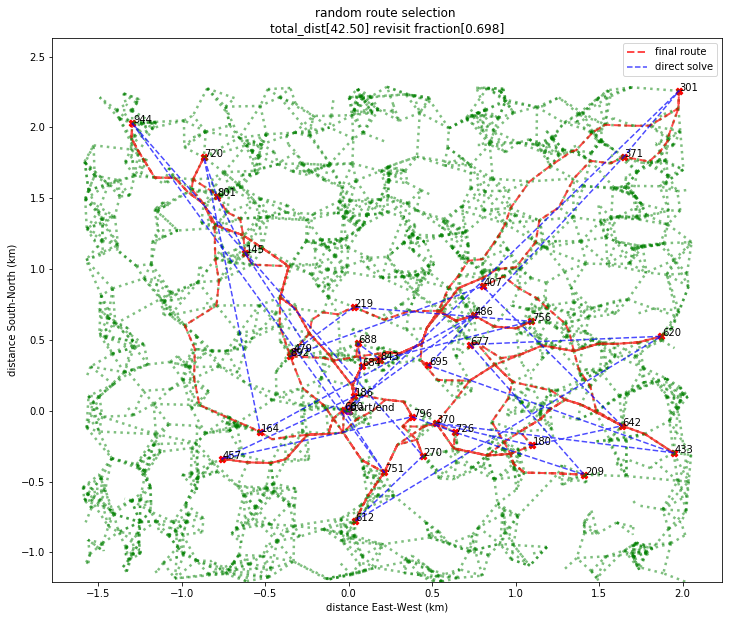

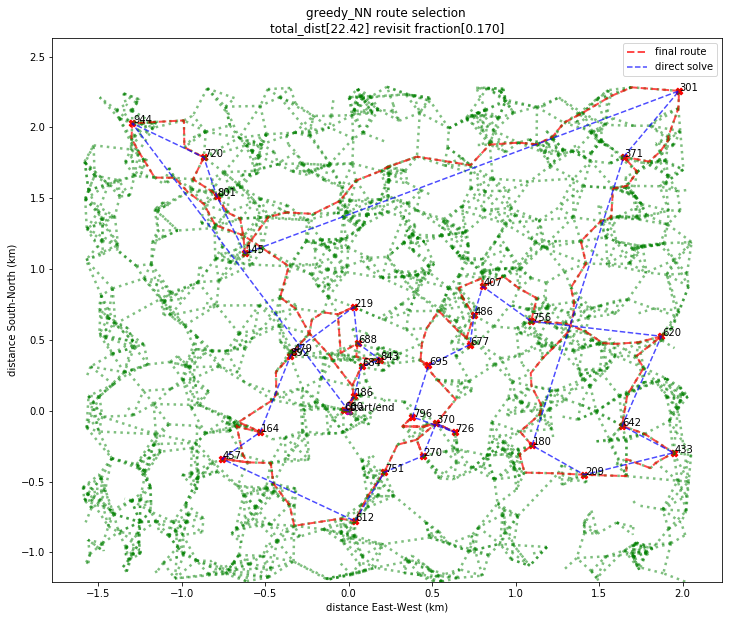

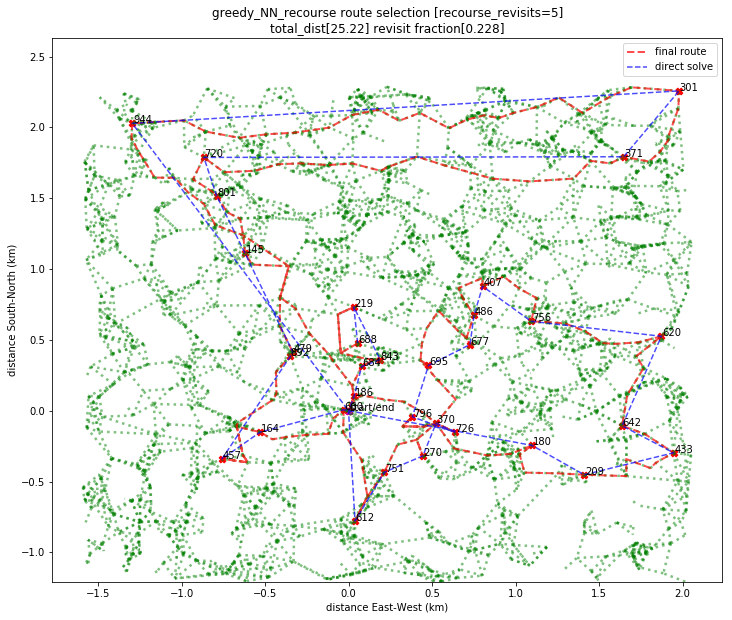

completed


In [5]:
tsp = TSP(stop_locations, dist_mat, walkways, recourse_revisits=5, debug=1)

tsp.reset_route_points()
tsp.add_stops(mail_stop_indices)
tsp.solve(solver_type='greedy_NN_recourse')
tsp.solve(solver_type='greedy_NN')
tsp.solve(solver_type='random')

# %matplotlib notebook
figsize = (12, 10)
tsp.plot_solutions('random', figsize=figsize)
tsp.plot_solutions('greedy_NN', figsize=figsize)
tsp.plot_solutions('greedy_NN_recourse', figsize=figsize)
print('completed')

### Solve the updated path problem

In this case, we have a few additional stops that we would like to integrate into our path planning. We can do this one of two different ways (in this limited scope). 
* resolve the TSP with the new points included in the solve
* attempt to update only the part of graph cycle that is nearest the new points, this is what the `quick_adjust` solver attempts to do

As we see below, the `quick_adjust_route()` method requires a 10th of the runtime, while produces a solution close (slightly longer) that of NN TSP route solution

finding approximate best routes for 37 stops
quick adjust: nearest 4 [(585, 892, 0.43034374841859463), (696, 892, 0.5736406517118247), (882, 209, 0.490038999058239), (63, 145, 0.6568329692494032)]
quick_adjust algorithm
   runtime     : 0.031s
   route dist  : [coarse: 23.197, fine: 28.464]
   validity    : [True] expanded[True]
   revisit_frac: [0.259]
finding approximate best routes for 37 stops
greedy_NN_recourse algorithm
   runtime     : 0.130s
   route dist  : [coarse: 21.518, fine: 26.692]
   validity    : [True] expanded[True]
   revisit_frac: [0.294]
finding approximate best routes for 37 stops
greedy_NN algorithm
   runtime     : 0.109s
   route dist  : [coarse: 20.330, fine: 25.464]
   validity    : [True] expanded[True]
   revisit_frac: [0.264]
finding approximate best routes for 37 stops
random algorithm
   runtime     : 1.004s
   route dist  : [coarse: 42.990, fine: 49.957]
   validity    : [True] expanded[True]
   revisit_frac: [0.691]


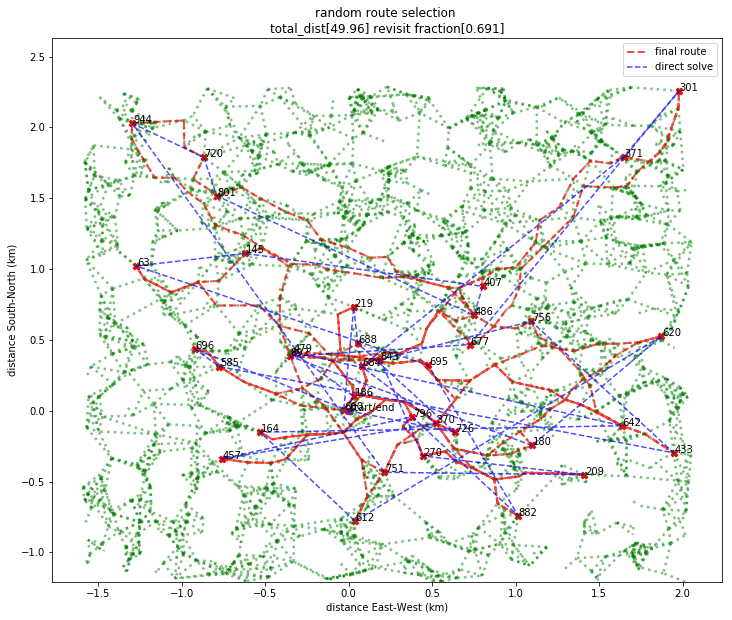

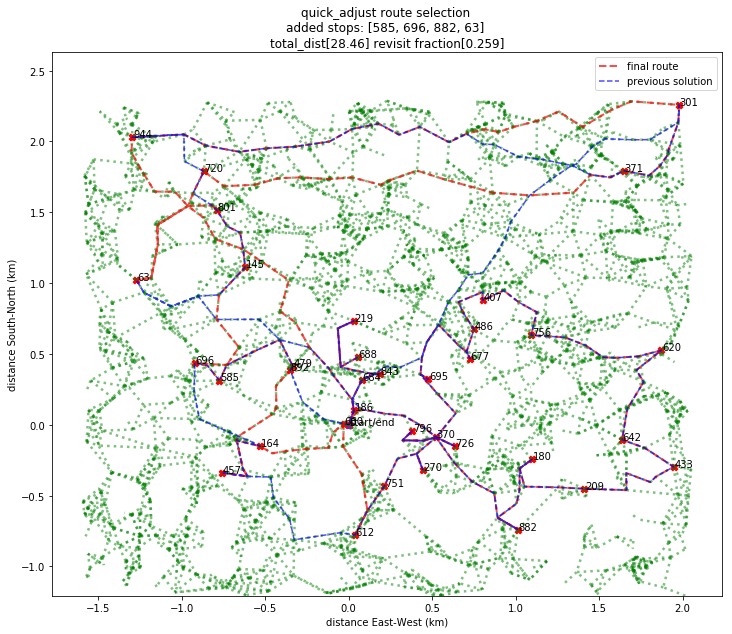

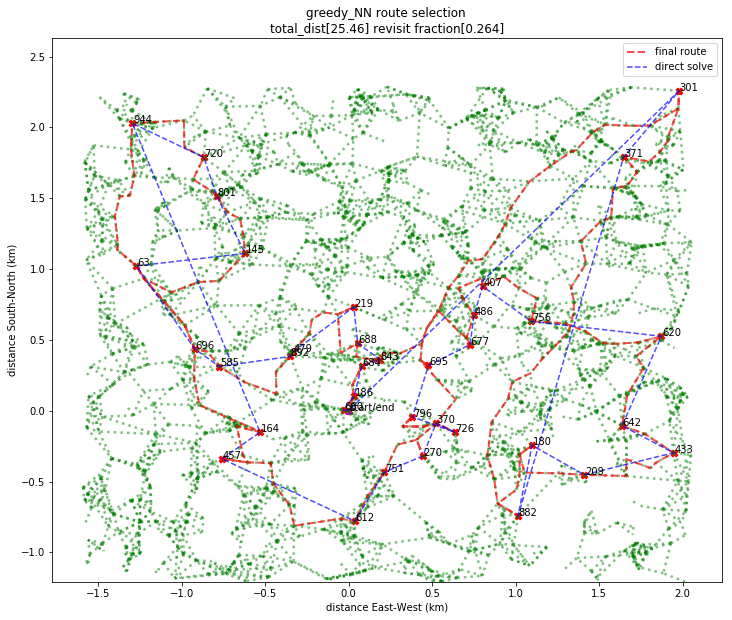

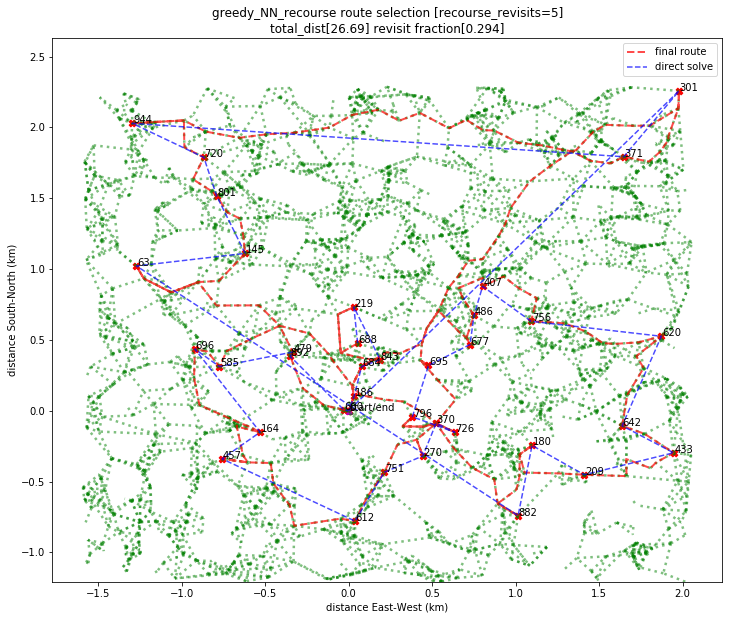

In [6]:
interesting_places_to_visit = [585, 696, 882, 63]
# tsp.debug = 3
tsp.add_stops(interesting_places_to_visit)

tsp.solve(solver_type='quick_adjust')
tsp.solve(solver_type='greedy_NN_recourse')
tsp.solve(solver_type='greedy_NN')
tsp.solve(solver_type='random')

figsize = (12, 10)
# %matplotlib notebook
tsp.plot_solutions('random', figsize=figsize)
tsp.plot_solutions('quick_adjust', figsize=figsize)
tsp.plot_solutions('greedy_NN', figsize=figsize)
tsp.plot_solutions('greedy_NN_recourse', figsize=figsize)
# print('completed')

### Experiment with the previous decision recourse 
Change the number of previous decisions that are allowed to be changed.

As we will see below, a naive attempt to correct within a limited number of legs is, at times, even more short-sighted than a simple greedy NN approach.

In [7]:
st = 'greedy_NN_recourse'

tsp = TSP(stop_locations, dist_mat, walkways, 
          solver_type=st, recourse_revisits=3, debug=0)

progress_bar = tqdm.tqdm(desc='MC trial', total=100, miniters=1)

stats = pd.DataFrame({})
for mc in range(10):
    mail_stop_indices_mc = generate_mail_stops(
        dist_mat, xrange, nstops_mail=30, 
        mail_stop_dist_laplace_param=0.22, po_start=0, 
        seed=(mc), debug=0)
    
    tsp.reset_route_points()
    tsp.add_stops(mail_stop_indices_mc)

    for rrv in range(1, 10):
        tsp.update_param('recourse_revisits', rrv)
        tsp.solve()
        stats = tsp.all_route_stats(
            solver_type=tsp.solver_type, stats=stats)
        progress_bar.n = 1 + rrv + mc * 10
        progress_bar.set_description('MC trial')
# %matplotlib notebook
# tsp.plot_solutions()

MC trial: 100%|██████████| 100/100 [00:12<00:00,  8.33it/s]

In [8]:
gb = stats.groupby('revisit_ndec')

# stats[['runtime_s', 'total_dist']].hist()

pd.DataFrame(dict(rt_mean=gb['runtime_s'].mean().values, rt_std=gb['runtime_s'].std().values, 
    dist_mean=gb['total_dist'].mean().values, dist_std=gb['total_dist'].std()))

,rt_mean,rt_std,dist_mean,dist_std
revisit_ndec,,,,
1,0.094270,0.032216,20.353829,3.550162
2,0.146998,0.072308,24.043383,6.236017
3,0.147448,0.061651,24.310172,6.363068
4,0.127336,0.041814,22.223752,4.341556
5,0.132466,0.048749,22.929729,4.739247
6,0.137324,0.061167,23.146942,5.288678
7,0.128434,0.049296,22.479943,5.139182
8,0.134553,0.057156,22.548687,5.289594
9,0.134096,0.057450,22.721623,5.632393


### Run Monte Carlo Experiment with different "walkways" and mailroutes
The idea here is to get different random connected edges (walkways) and random mailroutes within the 'field', and then to try added 'interesting' stops and to aggregate the average behavior including runtime and length of the routes.

If more time was to be put into the experiment, we could test the effect of various parameters in the simulation setup, like 
* the Laplacian spread parameter
* number of randomly drawn permutations for random path selection
* we could even change the 'recourse' allowed in the `greedy_NN_recourse` solver to try changing more than one previous edge
* experiment with accuracy of `quick_adjust` approach for different number of newly added points (fewer seems like it would be easier maintain a shorter length cycle)
* the number of stops required in the path solution will also greatly effect the efficacy of these solvers, varying it and checking the solutions and runtimes is also something of interest

For this limited MC simulation we show some results as histograms of total distance of routes, as well as the runtimes required to obtain said routes.

In [24]:
df_filename = './MC_multi_walkway_mailroute_DF.bin'
filefound = os.path.isfile(df_filename)
overwrite = False

if filefound:
    print(f'found dataframe file: {df_filename}')
    stats = pd.read_csv(df_filename)
else:
    tsp = TSP(stop_locations, dist_mat, walkways, 
              solver_type=st, 
              recourse_revisits=1, debug=0)

    tsp.init_monte_carlo()

    nMC_new_pathways = 10
    nMC_new_mailroutes = 10
    nUpdatesPer_mail_route = 3
    total_mc = nMC_new_pathways * nMC_new_mailroutes * nUpdatesPer_mail_route
    progress_bar
    nstops_add = 3

    progress_bar = tqdm.tqdm(desc='MC: nislanded[0]', total=total_mc, miniters=1)

    # stats = pd.DataFrame({})

    count = 0
    success = 0
    for mc_ww in range(nMC_new_pathways):
        walkways_mc, islanded = generate_walkways_from_complete_graph(
            dist_mat, xrange, max_nbhrs=12,
            walkway_dist_laplace_param=0.12, 
            fix_islands=True, seed=mc_ww, debug=0)

        tsp.dist_mat_edge_limited = walkways_mc

        for mc_mr in range(nMC_new_mailroutes):

            tsp.reset_route_points()

            mail_stop_indices_mc = generate_mail_stops(
                dist_mat, xrange, nstops_mail=30, 
                mail_stop_dist_laplace_param=0.22, po_start=0, 
                seed=(mc_ww*nMC_new_pathways+mc_mr), debug=0)

            tsp.add_stops(mail_stop_indices_mc)
            tsp.run_solvers_one_monte_carlo(is_update=False, auto_add_mc_stats=True)

            for up in range(nUpdatesPer_mail_route):
                stops_to_add = generate_interesting_stops(dist_mat, xrange, 
                    nstops_interesting=nstops_add,
                    seed=(mc_ww*nMC_new_pathways*nMC_new_mailroutes+mc_mr*nMC_new_mailroutes+up))

                tsp.add_stops(stops_to_add)
                tsp.run_solvers_one_monte_carlo(is_update=True, raise_error_invalid=False)

                if all([sol['is_valid_for_stops'] for sol in tsp.solutions.values()]):
                    tsp.mc_stats = tsp.all_route_stats(stats=tsp.mc_stats)
                    success += 1
                count += 1
                progress_bar.n = count
                progress_bar.set_description(f'MC: nislanded[{len(islanded)}]')


    nMC_actual, stats = tsp.finish_monte_carlo()
if overwrite or not(filefound):
    stats.to_csv(df_filename, index=False)

stats.head()

found dataframe file: ./MC_multi_walkway_mailroute_DF.bin


,solver,runtime_s,revisit,total_dist,is_update,points_skipped,revisit_ndec
0,greedy_NN,0.112520,0.285714,21.206799,False,0,NaN
1,greedy_NN_recourse,0.111520,0.285714,21.206799,False,0,1.0
2,random,0.738209,0.596708,36.536870,False,0,NaN
3,greedy_NN,0.110995,0.285714,22.181915,True,0,NaN
4,greedy_NN_recourse,0.110164,0.285714,22.181915,True,0,1.0


In [10]:
stats.groupby('solver')['runtime_s'].mean(), stats.groupby('solver')['total_dist'].mean()

(solver
 greedy_NN             0.106900
 greedy_NN_recourse    0.107181
 quick_adjust          0.030229
 random                0.795971
 Name: runtime_s, dtype: float64, solver
 greedy_NN             21.725757
 greedy_NN_recourse    21.725757
 quick_adjust          23.344738
 random                41.348260
 Name: total_dist, dtype: float64)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10a5b79e8>,
      dtype=object)

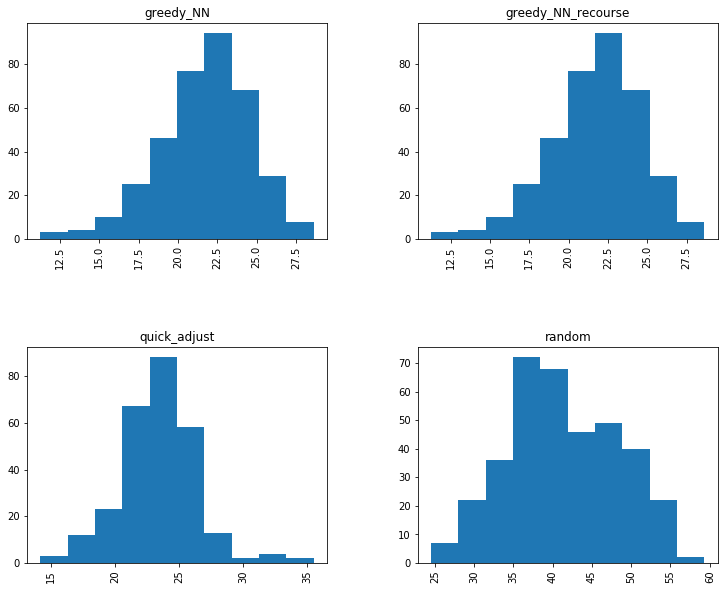

In [21]:
stats.fillna(value=-1).hist(by='solver', column='total_dist', figsize=(12, 10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10a55ca90>,
      dtype=object)

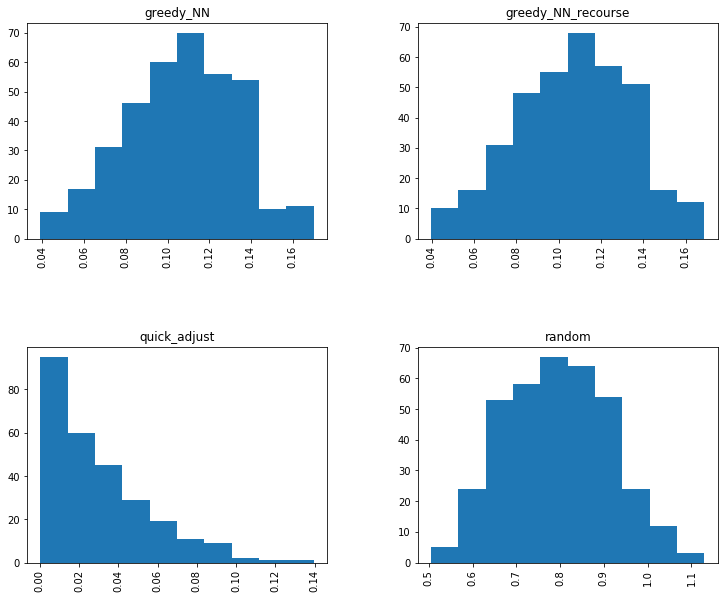

In [22]:
stats.fillna(value=-1).hist(by='solver', column='runtime_s', figsize=(12, 10))

In [12]:
# # mc_ww, mc_mr, up = 0, 2, 3
# tsp.debug = 3  

walkways_mc, islanded = generate_walkways_from_complete_graph(
        dist_mat, xrange, max_nbhrs=15,
        walkway_dist_laplace_param=0.12, 
        fix_islands=True, seed=mc_ww, debug=0)

tsp.reset_route_points()
# tsp.init_monte_carlo()

mail_stop_indices_mc = generate_mail_stops(
    dist_mat, xrange, nstops_mail=30, 
    mail_stop_dist_laplace_param=0.22, po_start=0, 
    seed=(mc_ww*nMC_new_pathways+mc_mr), debug=0)

tsp.add_stops(mail_stop_indices_mc)

# tsp.solutions = {}
for solver in tsp.base_algorithm_types:
    tsp.solve(solver_type=solver)
    
for up in range(nUpdatesPer_mail_route):
    stops_to_add = generate_interesting_stops(dist_mat, xrange, 
        nstops_interesting=nstops_add,
        seed=(mc_ww*nMC_new_pathways*nMC_new_mailroutes+mc_mr*nMC_new_mailroutes+up))
    
# stops_to_add = generate_interesting_stops(dist_mat, xrange, 
#     nstops_interesting=nstops_add,
#     seed=(mc_ww*nMC_new_pathways*nMC_new_mailroutes+mc_mr*nMC_new_mailroutes+up))

    tsp.add_stops(stops_to_add)
    for solver in tsp.base_algorithm_types:
        tsp.solve(solver_type=solver, raise_error_invalid=False)
    
# for solver in tsp.base_algorithm_types:
#     tsp.plot_solutions(solver_type=solver, figsize=(12, 10))